In [76]:
# Importing the required libraries
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [78]:
class MazeGenerator:
    def __init__(self, width, height, density, num_obstacles, random_seed=None):
        self.width = width
        self.height = height
        self.density = density
        self.num_obstacles = num_obstacles
        self.random_seed = random_seed
        self.grid = self.generate_random_maze()
        self.obstacles = self.init_obstacles()

    def generate_random_maze(self):

        if self.random_seed is not None:
            random.seed(self.random_seed)  # Set random seed for Python's random module

        maze = np.random.choice([0, 1], size=(self.height, self.width), p=[1-self.density, self.density])
        maze[0, 0] = 0  # Entrance
        maze[-1, -1] = 0  # Exit     
        
        return maze


    def init_obstacles(self):

        obstacles = []
        for _ in range(self.num_obstacles):
            obstacle = self.generate_obstacle_position()
            obstacles.append(obstacle)
        return obstacles

    def generate_obstacle_position(self):
        while True:
            obstacle = [random.randint(0, self.height - 1), random.randint(0, self.width - 1)]
            if self.grid[obstacle[0], obstacle[1]] == 0:  # Check if the position is empty
                return obstacle

    def update_obstacles(self):
        if self.random_seed is not None:
            random.seed(self.random_seed)  # Set random seed for Python's random module

        # Convert obstacles list to a set of tuples for faster lookup
        obstacle_set = set(tuple(obstacle) for obstacle in self.obstacles)

        # Iterate through each obstacle
        for obstacle in self.obstacles:
            # Store the original position
            original_position = tuple(obstacle)

            # Try random movements until a valid one is found
            while True:
                # Generate a random direction (up, down, left, right)
                direction = random.choice([(0, 1), (0, -1), (1, 0), (-1, 0)])
                
                # Calculate new position based on the direction
                new_position = (obstacle[0] + direction[0], obstacle[1] + direction[1])
                
                # Check if the new position is within the maze boundaries and not a wall
                if (0 <= new_position[0] < self.height and
                    0 <= new_position[1] < self.width and
                    self.grid[new_position[0], new_position[1]] != 1):
                    
                    # Check if the new position collides with another obstacle
                    if new_position not in obstacle_set:
                        # Update the obstacle position
                        obstacle[:] = new_position
                        # Update the set of obstacle positions
                        obstacle_set.remove(original_position)
                        obstacle_set.add(new_position)
                        break



    def display(self, start_positions, goal_positions, paths=None, animate=False, tres = 1):
        fig, ax = plt.subplots(figsize=(12, 12))  # Adjust figsize as needed
        ax.imshow(self.grid, cmap='binary')
        self.obstacles = self.init_obstacles()

        if isinstance(start_positions, list):
            # Mark the entrance and exit positions for each pair
            for i in range(len(start_positions)):
                ax.scatter(start_positions[i][1], start_positions[i][0], color='red', marker='o', s=50, label='Start')
                ax.scatter(goal_positions[i][1], goal_positions[i][0], color='green', marker='o', s=50, label='Goal')

            if paths and animate:
                # Create a function to update the animation
                def update(frame):
                    ax.clear()
                    ax.imshow(self.grid, cmap='binary')
                    self.update_obstacles()
                    for obstacle in self.obstacles:
                        ax.scatter(obstacle[1], obstacle[0], color='red', marker='s', s=50, label='Obstacle')                    
                    for i in range(len(start_positions)):
                        ax.scatter(start_positions[i][1], start_positions[i][0], color='red', marker='o', s=50, label='Start')
                        ax.scatter(goal_positions[i][1], goal_positions[i][0], color='green', marker='o', s=50, label='Goal')
                        path_x, path_y = zip(*paths[i][:frame+1])
                        ax.plot(path_y, path_x, marker='o', markersize=1, label=f'Path {i+1}')
                        ax.plot(path_y[-1], path_x[-1], color='blue', marker='*', markersize=tres)  # Marker on the moving agent
                    #ax.legend()
                    ax.legend().set_visible(False)

                # Create the animation
                ani = FuncAnimation(fig, update, frames=len(paths[0]), interval=10)
                plt.show()
                return ani
        else:
            # Mark the entrance and exit positions
            ax.scatter(start_positions[1], start_positions[0], color='red', marker='o', s=50, label='Start')
            ax.scatter(goal_positions[1], goal_positions[0], color='green', marker='o', s=50, label='Goal')

            if paths and animate:
                # Create a function to update the animation
                print('========test===========')
                def update(frame):
                    ax.clear()
                    ax.imshow(self.grid, cmap='binary')
                    self.update_obstacles()
                    for obstacle in self.obstacles:
                        ax.scatter(obstacle[1], obstacle[0], color='red', marker='s', s=50, label='Obstacle')
                    ax.scatter(start_positions[1], start_positions[0], color='red', marker='o', s=50, label='Start')
                    ax.scatter(goal_positions[1], goal_positions[0], color='green', marker='o', s=50, label='Goal')
                    path_x, path_y = zip(*paths[:frame+1])
                    ax.plot(path_y, path_x, marker='o', color='blue', markersize=1, label='Learned Path')
                    ax.plot(path_y[-1], path_x[-1], color='blue', marker='*', markersize=tres)  # Marker on the moving agent
                    #ax.legend()
                    ax.legend().set_visible(False)

                # Create the animation
                ani = FuncAnimation(fig, update, frames=len(paths), interval=10)
                plt.show()
                return ani
        plt.legend()
        plt.show()




In [107]:
# Create a maze generator instance
# Define the dimensions of the maze
width = 32
height = 32

# Define the density of walls in the maze (between 0 and 1)
density = 0.25
maze_generator = MazeGenerator(width, height, density, 0)

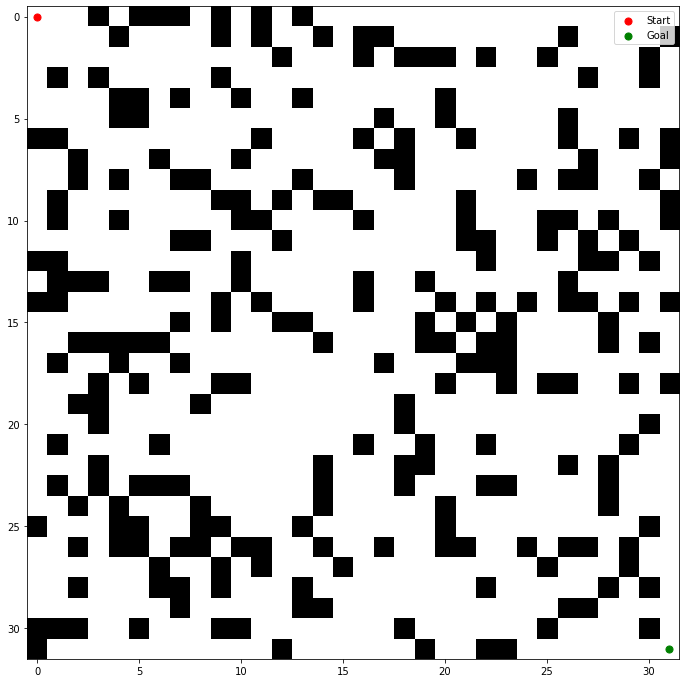

In [108]:


# Specify the starting and goal positions
startPos = (0,0)
goalPos = (width-1,height-1)

# Display the generated maze as a figure with starting and goal positions
maze_generator.display(startPos, goalPos)

/tmp/ipykernel_3402322/3393238464.py:23: RuntimeWarning: invalid value encountered in double_scalars
  delta = max(delta, abs(v - self.V[i, j]))


precesion = 2.0


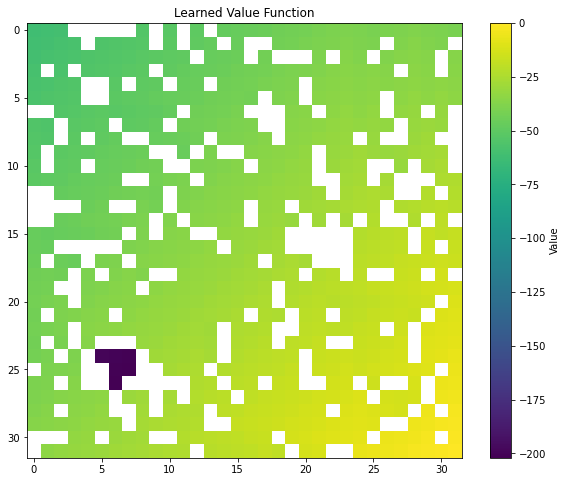

In [112]:
class ValueIterationMazeSolver_V1:
    def __init__(self, maze, startPos, goalPos, gamma=1, epsilon=1e-4):
        self.maze = maze
        self.startPos = startPos
        self.goalPos = goalPos
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Convergence threshold
        self.height, self.width = maze.shape  # Get maze dimensions
        self.V = np.zeros((self.height, self.width))-00  # Value function initialized to zeros
        self.max_it = 100

    def value_iteration(self):
        num_it = 0
        while True:
            delta = 0
            for i in range(self.height):
                for j in range(self.width):
                    if self.maze[i, j] == 1:  # Skip if it's a wall
                        self.V[i, j] = -np.inf
                        continue
                    v = self.V[i, j]
                    self.V[i, j] = self.compute_max_value(i, j)
                    delta = max(delta, abs(v - self.V[i, j]))
            if delta < self.epsilon:
                break
            num_it = num_it + 1
            if num_it > self.max_it:
                print('precesion = {}'.format(delta))
                break

    def greedy_policy(self, i, j):
        if (i, j) == self.goalPos:
            return 0  # Value of the goal state is 0
        
        max_value = -np.inf
        next_v = np.zeros((4,1))
        # greedy_policy
        ac_idx = 0
        actions = [(0, -1), (0, 1), (-1, 0), (1, 0)]
        for action in actions:  # Possible actions: up, down, left, right
            i_, j_ = i + action[0], j + action[1]
            if 0 <= i_ < self.height and 0 <= j_ < self.width and self.maze[i_, j_] != 1:
                value = self.V[i_, j_]
                next_v[ac_idx] = value
                max_value = max(max_value, value)
            else:
                next_v[ac_idx] = -np.inf
            ac_idx = ac_idx + 1

        greedy_actions = [i for i, tmp_v in enumerate(next_v) if tmp_v == max_value]
                  
        return actions[np.random.choice(greedy_actions)]

    def compute_max_value(self, i, j):
        if (i, j) == self.goalPos:
            return 0  # Value of the goal state is 0
        max_value = -np.inf
        for action in [(0, -1), (0, 1), (-1, 0), (1, 0)]:  # Possible actions: up, down, left, right
            i_, j_ = i + action[0], j + action[1]
            if 0 <= i_ < self.height and 0 <= j_ < self.width and self.maze[i_, j_] != 1:
                value = self.V[i_, j_]
                max_value = max(max_value, value)
        return -1 + self.gamma * max_value  # Reward: -1 for every movement

    def get_optimal_path(self):
        path = [self.startPos]
        i, j = self.startPos
        actions = [(0, -1), (0, 1), (-1, 0), (1, 0)]
        while (i, j) != self.goalPos:
            max_value = -np.inf
            next_pos = None
            action = self.greedy_policy(i,j)
            i_, j_ = i + action[0], j + action[1]
            next_pos = (i_, j_)
            path.append(next_pos)
            i, j = next_pos
        return path
    

    def plot_value_function(self):
        plt.figure(figsize=(10, 8))  # Adjust the width and height as needed
        plt.imshow(self.V, cmap='viridis', interpolation='nearest')
        plt.colorbar(label='Value')
        plt.title('Learned Value Function')
        plt.show()



# Example usage:
solver = ValueIterationMazeSolver_V1(maze_generator.grid, startPos, goalPos)
solver.value_iteration()
solver.plot_value_function()

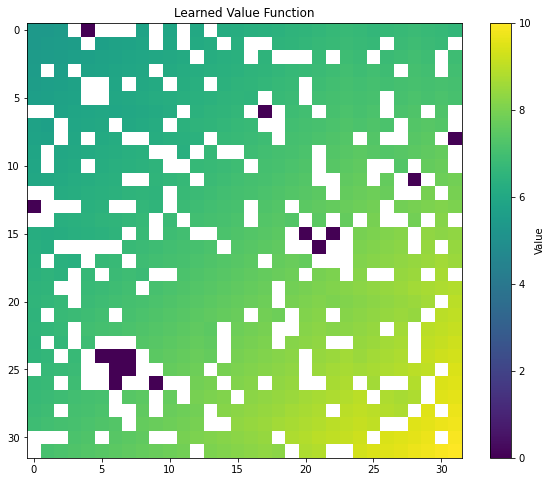

In [114]:
class ValueIterationMazeSolver:
    def __init__(self, maze, startPos, goalPos, gamma=0.99, epsilon=1e-4):
        self.maze = maze
        self.startPos = startPos
        self.goalPos = goalPos
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Convergence threshold
        self.height, self.width = maze.shape  # Get maze dimensions
        self.V = np.zeros((self.height, self.width))-00  # Value function initialized to zeros
        self.max_it = 5000

    def value_iteration(self):
        num_it = 0
        while True:
            delta = 0
            for i in range(self.height):
                for j in range(self.width):
                    if self.maze[i, j] == 1:  # Skip if it's a wall
                        self.V[i, j] = -np.inf
                        continue
                    v = self.V[i, j]
                    self.V[i, j] = self.compute_max_value(i, j)
                    delta = max(delta, abs(v - self.V[i, j]))
            if delta < self.epsilon:
                break
            num_it = num_it + 1
            if num_it > self.max_it:
                print('precesion = {}'.format(delta))
                break

    def greedy_policy(self, i, j):
        if (i, j) == self.goalPos:
            return 0  # Value of the goal state is 0
        
        max_value = -np.inf
        next_v = np.zeros((4,1))
        # greedy_policy
        ac_idx = 0
        actions = [(0, -1), (0, 1), (-1, 0), (1, 0)]
        for action in actions:  # Possible actions: up, down, left, right
            i_, j_ = i + action[0], j + action[1]
            if 0 <= i_ < self.height and 0 <= j_ < self.width and self.maze[i_, j_] != 1:
                value = self.V[i_, j_]
                next_v[ac_idx] = value
                max_value = max(max_value, value)
            else:
                next_v[ac_idx] = -np.inf
            ac_idx = ac_idx + 1

        greedy_actions = [i for i, tmp_v in enumerate(next_v) if tmp_v == max_value]
                  
        return actions[np.random.choice(greedy_actions)]

    def compute_max_value(self, i, j):
        if (i, j) == self.goalPos:
            return 10  # Value of the goal state is 0
        max_value = -np.inf
        for action in [(0, -1), (0, 1), (-1, 0), (1, 0), (0,0)]:  # Possible actions: up, down, left, right
            i_, j_ = i + action[0], j + action[1]
            if 0 <= i_ < self.height and 0 <= j_ < self.width and self.maze[i_, j_] != 1:
                value = self.V[i_, j_]
                max_value = max(max_value, value)
        return self.gamma * max_value  # Reward: -1 for every movement

    def get_optimal_path(self):
        path = [self.startPos]
        i, j = self.startPos
        actions = [(0, -1), (0, 1), (-1, 0), (1, 0)]
        while (i, j) != self.goalPos:
            max_value = -np.inf
            next_pos = None
            action = self.greedy_policy(i,j)
            i_, j_ = i + action[0], j + action[1]
            next_pos = (i_, j_)
            path.append(next_pos)
            i, j = next_pos
        return path
    

    def plot_value_function(self):
        plt.figure(figsize=(10, 8))  # Adjust the width and height as needed
        plt.imshow(self.V, cmap='viridis', interpolation='nearest')
        plt.colorbar(label='Value')
        plt.title('Learned Value Function')
        plt.show()



# 
solver = ValueIterationMazeSolver(maze_generator.grid, startPos, goalPos)
solver.value_iteration()
solver.plot_value_function()

Optimal Path: [(0, 0), (0, 1), (1, 1), (1, 2), (2, 2), (2, 3), (2, 4), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (4, 8), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (6, 12), (6, 13), (6, 14), (7, 14), (8, 14), (8, 15), (8, 16), (8, 17), (9, 17), (9, 18), (10, 18), (10, 19), (11, 19), (12, 19), (12, 20), (13, 20), (13, 21), (13, 22), (13, 23), (13, 24), (13, 25), (14, 25), (15, 25), (16, 25), (16, 26), (16, 27), (17, 27), (18, 27), (19, 27), (19, 28), (19, 29), (19, 30), (19, 31), (20, 31), (21, 31), (22, 31), (23, 31), (24, 31), (25, 31), (26, 31), (27, 31), (28, 31), (29, 31), (30, 31), (31, 31)]
========test===========


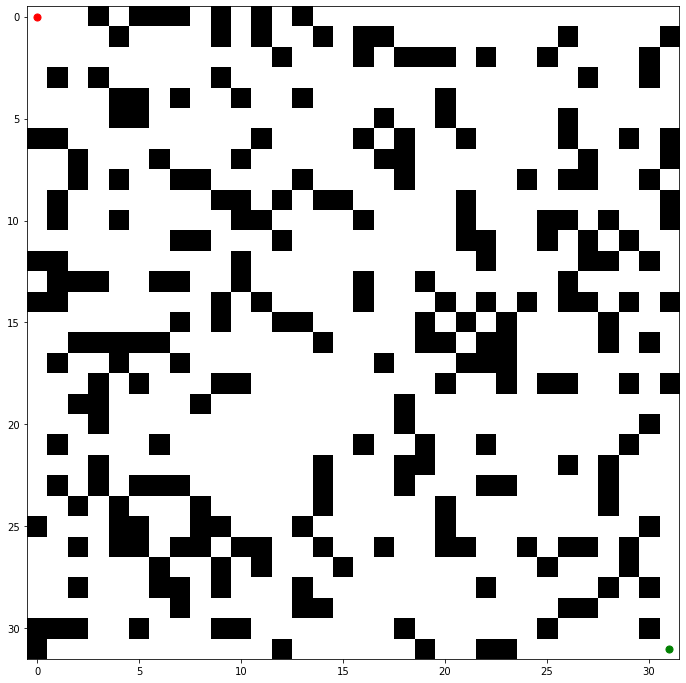

In [115]:
optimal_path = solver.get_optimal_path()
print("Optimal Path:", optimal_path)
# Display the maze with the learned path
ani = maze_generator.display(startPos, goalPos, optimal_path, animate=True, tres=10)
ani.save('test_32_v2.gif', writer='pillow')

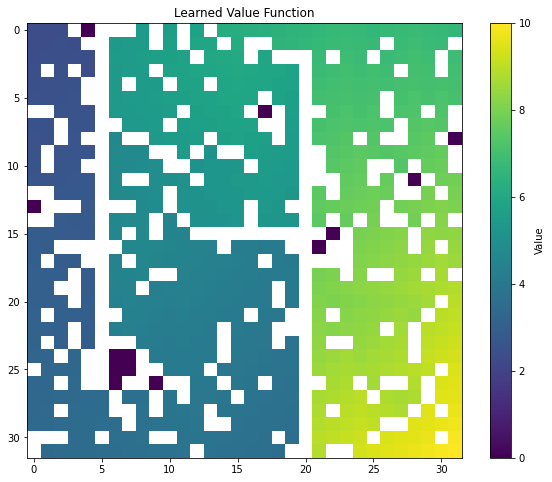

In [122]:
maze_generator.grid[0:25,5] = 1
maze_generator.grid[3:32,20] = 1
maze_generator.grid[15,12:20] = 1
solver = ValueIterationMazeSolver(maze_generator.grid, startPos, goalPos)
solver.value_iteration()
solver.plot_value_function()

Optimal Path: [(0, 0), (1, 0), (1, 1), (2, 1), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (6, 3), (7, 3), (8, 3), (9, 3), (10, 3), (11, 3), (11, 4), (12, 4), (13, 4), (14, 4), (14, 3), (15, 3), (15, 2), (15, 1), (16, 1), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (24, 1), (25, 1), (25, 2), (25, 3), (26, 3), (27, 3), (28, 3), (29, 3), (29, 4), (29, 5), (29, 6), (30, 6), (30, 7), (30, 8), (29, 8), (29, 9), (29, 10), (28, 10), (28, 11), (28, 12), (27, 12), (26, 12), (25, 12), (25, 11), (24, 11), (23, 11), (22, 11), (21, 11), (20, 11), (19, 11), (18, 11), (17, 11), (16, 11), (16, 10), (16, 9), (16, 8), (15, 8), (14, 8), (13, 8), (12, 8), (12, 9), (11, 9), (11, 10), (11, 11), (12, 11), (12, 12), (12, 13), (11, 13), (11, 14), (11, 15), (11, 16), (11, 17), (10, 17), (9, 17), (9, 16), (8, 16), (8, 15), (7, 15), (6, 15), (5, 15), (4, 15), (3, 15), (2, 15), (1, 15), (0, 15), (0, 16), (0, 17), (0, 18), (1, 18), (1, 19), (1, 20), (1, 21), (2, 21), (3, 21), (4, 21

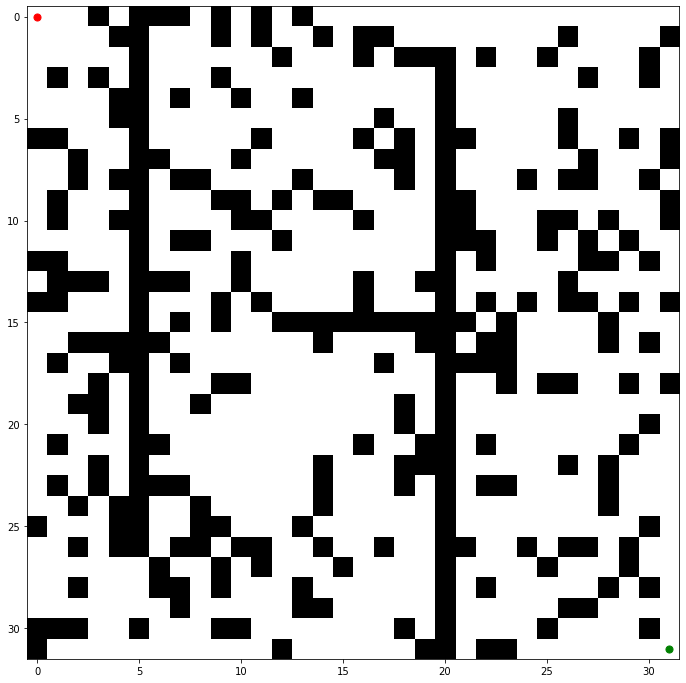

In [123]:
optimal_path = solver.get_optimal_path()
print("Optimal Path:", optimal_path)
# Display the maze with the learned path
ani = maze_generator.display(startPos, goalPos, optimal_path, animate=True, tres=10)
ani.save('test_32_v5.gif', writer='pillow')

In [124]:
# Create a maze generator instance
# Define the dimensions of the maze
width = 128
height = 128

# Define the density of walls in the maze (between 0 and 1)
density = 0.25
maze_generator = MazeGenerator(width, height, density, 0)

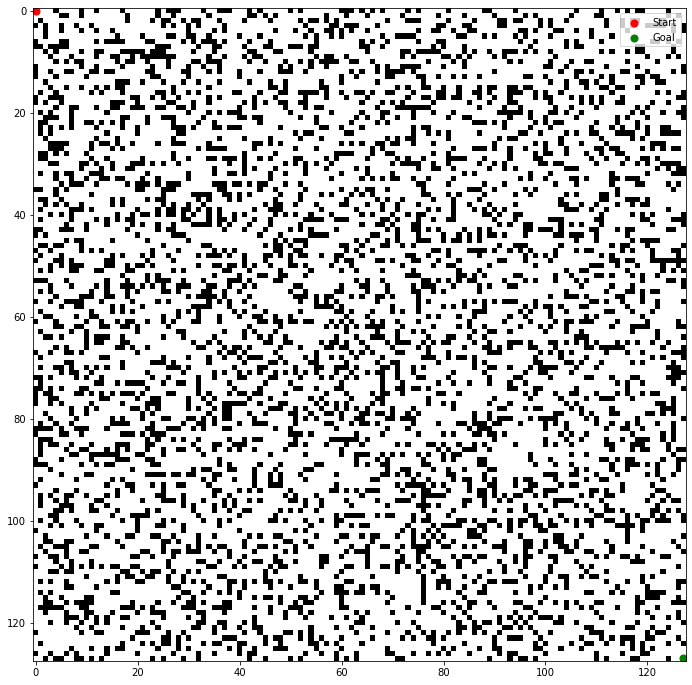

In [125]:

# Specify the starting and goal positions
startPos = (0,0)
goalPos = (width-1,height-1)

# Display the generated maze as a figure with starting and goal positions
maze_generator.display(startPos, goalPos)

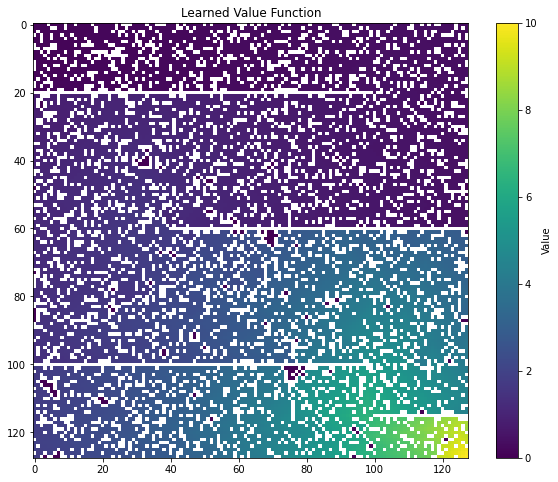

In [130]:
maze_generator.grid[20, 0:100] = 1
maze_generator.grid[60,40:128] = 1
maze_generator.grid[100,0:100] = 1
maze_generator.grid[115,100:132] = 1

solver = ValueIterationMazeSolver(maze_generator.grid, startPos, goalPos)
solver.value_iteration()
solver.plot_value_function()

Optimal Path: [(0, 0), (1, 0), (1, 1), (1, 2), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 15), (3, 16), (3, 17), (3, 18), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (5, 22), (5, 23), (5, 24), (5, 25), (6, 25), (6, 26), (6, 27), (6, 28), (7, 28), (8, 28), (9, 28), (10, 28), (11, 28), (12, 28), (13, 28), (14, 28), (15, 28), (15, 29), (15, 30), (14, 30), (14, 31), (13, 31), (13, 32), (13, 33), (13, 34), (13, 35), (13, 36), (13, 37), (14, 37), (14, 38), (14, 39), (14, 40), (14, 41), (13, 41), (13, 42), (13, 43), (13, 44), (13, 45), (13, 46), (13, 47), (13, 48), (13, 49), (13, 50), (13, 51), (13, 52), (13, 53), (13, 54), (13, 55), (13, 56), (13, 57), (13, 58), (13, 59), (14, 59), (15, 59), (15, 60), (15, 61), (15, 62), (15, 63), (15, 64), (15, 65), (15, 66), (15, 67), (15, 68), (14, 68), (14, 69), (14, 70), (14, 71), (14, 72), (14, 73), (14, 74), (14, 75), (15, 75), (16, 75), (16, 76), (16, 77), (16, 78), (15, 

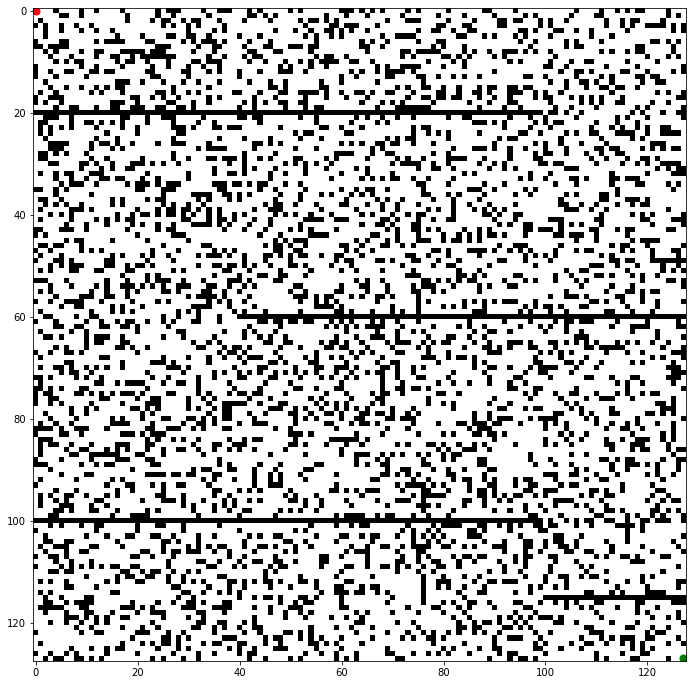

In [131]:
optimal_path = solver.get_optimal_path()
print("Optimal Path:", optimal_path)
# Display the maze with the learned path
ani = maze_generator.display(startPos, goalPos, optimal_path, animate=True, tres=0.01)
ani.save('test_128_v2.gif', writer='pillow')